# Metody Obliczeniowe w Nauce i Technice Laboratorium 4
## Symulowane wyżarzanie
### Paweł Gorgolewski

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import namedtuple
from typing import List

## 1. TSP

##### Struktury użyte w rozwiązaniu:
1) Point - namedtuple zawierająca współrzędne oraz id miasta
2) Temperature - klasa wykorzystywana do obsługi funkcji temperatury
3) TSP - klasa wykorzystywana do obliczenia najkrótszej trasy

In [62]:
Point = namedtuple("Point", ["x", "y", "id"])

class Temperature:
    _probability = 1
    _delta = 1

    def __init__(self, max_iterations: int):
        self._max_temp = max_iterations
        self._temp = self._max_temp
        self.strategy = self.linear

    @property
    def probability(self):
        return self._probability

    def linear(self):
        self._temp -= self._delta
        self._probability = self._temp / self._max_temp

    def cool_down(self):
        self.strategy()

class TSP:
    _distances_over_time = list()
    def __init__(self, cities: List[Point], max_iterations: int):
        self.set(cities, max_iterations)

    def set(self, cities: List[Point], max_iterations: int):
        self._cities = cities
        self._n = len(cities)
        self._temp = Temperature(max_iterations)
        self._max_iterations = max_iterations
        self._cities_distance = self._calculate_distances()
        self._is_used = False
        self._best_cities_order = self._cities
        self._best_distance = sum(self._cities_distance[self._cities[i].id, self._cities[(i+1) % self._n].id] for i in range(self._n))

    def solve(self):
        if self._is_used:
            raise Exception("Use .set() for TSP object to use it again")

        curr_distance = self._best_distance
        self._best_cities_order = self._cities.copy()
        self._distances_over_time.append(curr_distance)
        for step in range(1, self._max_iterations+1):
            index1, index2 = np.random.choice(range(self._n), 2, replace=False)
            distance_difference = self._calculate_difference(index1, index2)

            if distance_difference > 0 or np.random.random() < self._temp.probability:
                self._cities[index1], self._cities[index2] = self._cities[index2], self._cities[index1]
                curr_distance -= distance_difference

            if curr_distance < self._best_distance:
                self._best_distance = curr_distance
                self._best_cities_order = self._cities.copy()

            self._temp.cool_down()
            self._distances_over_time.append(curr_distance)

        self._is_used = True

    def _calculate_difference(self, i1: int, i2: int):
        p1_prev, p1, p1_next = self._cities[(i1-1) % self._n], self._cities[i1], self._cities[(i1+1) % self._n]
        p2_prev, p2, p2_next = self._cities[(i2-1) % self._n], self._cities[i2], self._cities[(i2+1) % self._n]
        after_change = self._cities_distance[p1.id, p2_next.id] + self._cities_distance[p1.id, p2_prev.id] +\
                       self._cities_distance[p2.id, p1_next.id] + self._cities_distance[p2.id, p1_prev.id]
        before_change = self._cities_distance[p1.id, p1_next.id] + self._cities_distance[p1.id, p1_prev.id] +\
                        self._cities_distance[p2.id, p2_next.id] + self._cities_distance[p2.id, p2_prev.id]

        return before_change - after_change

    def _calculate_distances(self):
        distances = np.eye(self._n, self._n)
        for i in range(1, self._n):
            for j in range(i+1, self._n):
                i_id, j_id = self._cities[i].id, self._cities[j].id
                distances[i_id, j_id] = distances[j_id, i_id] = self.point_distance(self._cities[i], self._cities[j])

        return distances

    def draw_road(self):
        plt.figure(figsize=(20, 15), dpi=80)
        G = nx.DiGraph()
        pos = dict()
        for i in range(self._n):
            G.add_node(i)
            pos[i] = (self._cities[i].x, self._cities[i].y)

        for i in range(self._n):
            G.add_edge(i, (i+1) % self._n)

        nx.draw_networkx_nodes(G, pos, node_color = 'tab:red')
        nx.draw_networkx_labels(G, pos, font_size = 3, font_color = "black")
        nx.draw_networkx_edges(G, pos)
        plt.title(f"TOTAL DISTANCE: {self._best_distance}")

        plt.show()

    def draw_anneling(self):
        plt.plot(list(range(self._max_iterations+1)), self._distances_over_time)
        plt.show()

    @staticmethod
    def point_distance(p1: Point, p2: Point):
        return np.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)



pamietac najlepszy stan oraz odpalic pare razy bo sochastyczny

##### Funkcje do generowania listy punktów

In [63]:
def generate_randoms(n):
    return [Point(np.random.random(), np.random.random(), i) for i in range(n)]
#
# def get_randoms_with_groups(n, groups, boundary):
#     result = list()
#     for i in range(groups):
#         result.extend([(np.random.random() + i), np.random.random() + i])
#
#     np.random.shuffle(result)
#     return result


# Jeszcze normalny jakoś tu zrób i wgl chyba to jest źle ale już nie ważne

BEFORE SOLVER. ITER NUMBER: 0


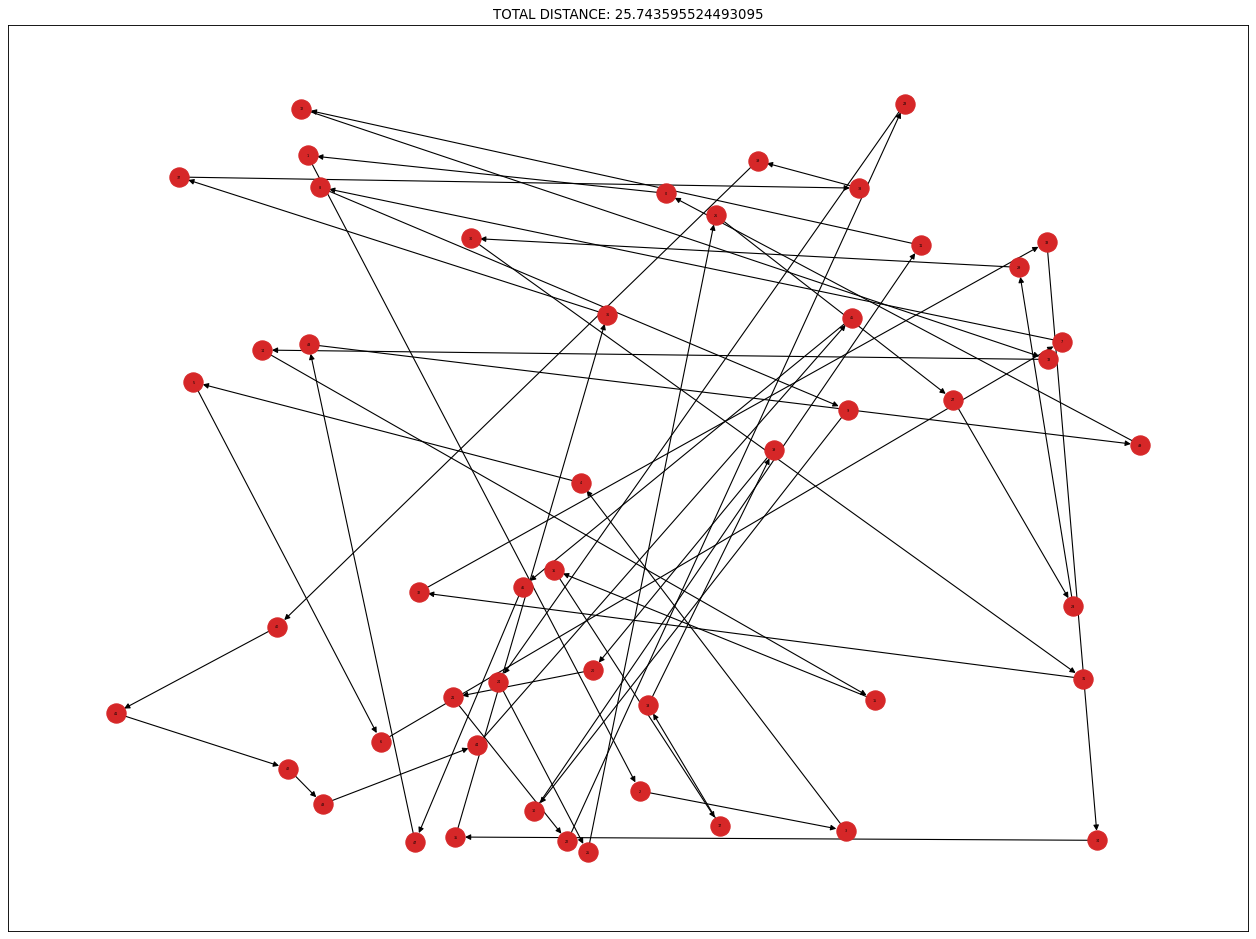

AFTER SOLVER. ITER NUMBER: 0


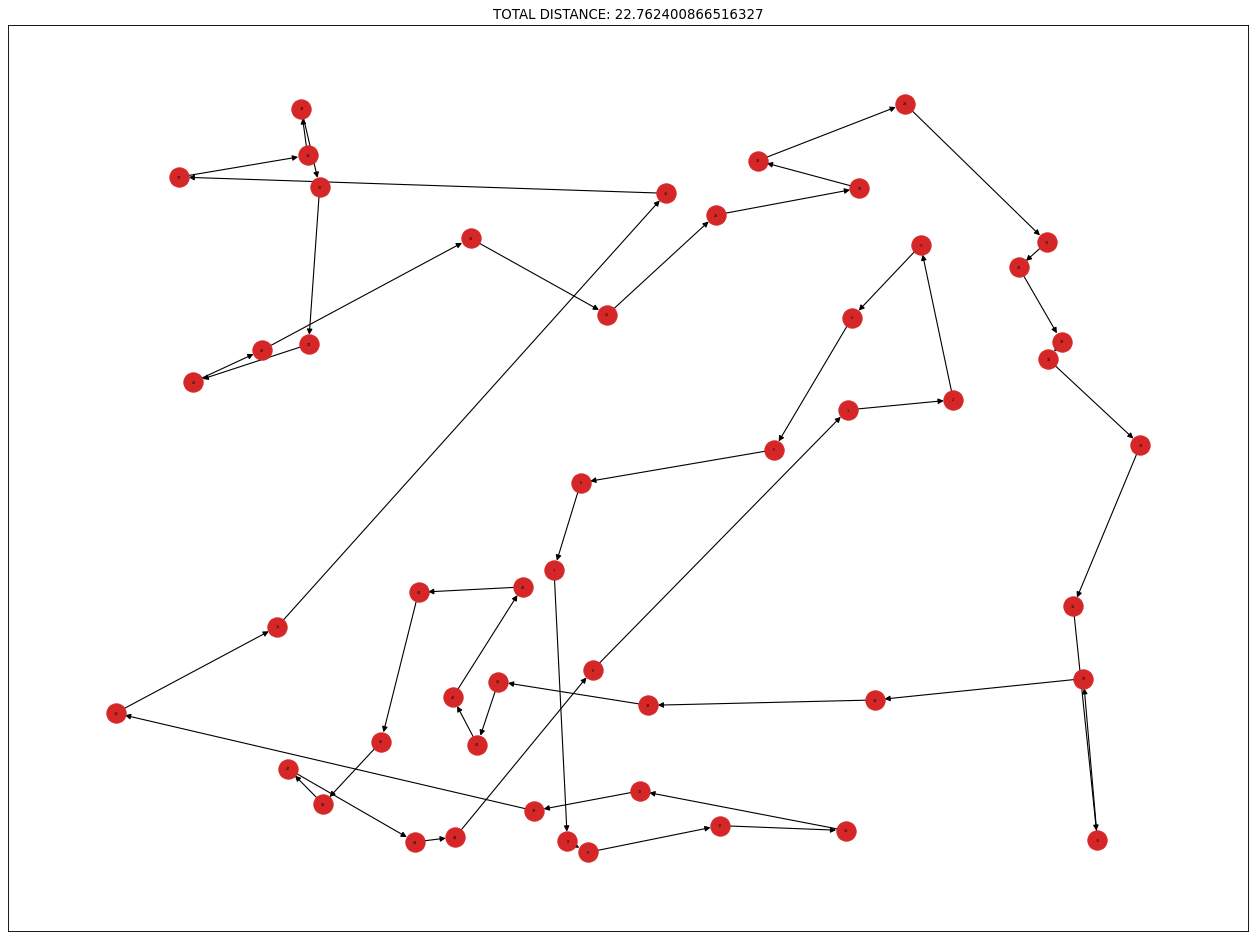

ValueError: x and y must have same first dimension, but have shapes (1000001,) and (2000002,)

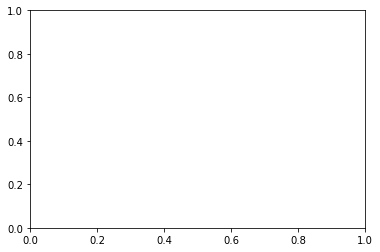

In [65]:
repeat = 1
n, max_iter = 50, 10**6
cities = generate_randoms(n)
tsp = TSP(cities, max_iter)
for i in range(repeat):
    print(f"BEFORE SOLVER. ITER NUMBER: {i}")
    tsp.draw_road()
    tsp.solve()
    print(f"AFTER SOLVER. ITER NUMBER: {i}")
    tsp.draw_road()
    tsp.draw_anneling()
    tsp.set(cities, max_iter)

## 2. Obraz binarny
zadanie otwrate, definiujemy wlasne zasady fizyki. testujemy rozne rodzaje sasiedztwa 6 albo i więcej. Liczymy energie potencjalne np. suma czarnych sąsiadów. Energia potencjalna jest im wieksza tym bardziej czegoś nie chcemy. Np czarny chce być z białymi to energia to ilość czarnych sąsiadów. Macierz ma być duża min 256/256. Ma być stała liczba czarnych punktów, Optymalizujemy tak aby wykres wyżarzania był spoko. O ocenie za to zadanie decyduje ilość ciekawych rozwiązań. SPR przy tym samym ukłądzie i funkcji energi i sąsiedztwie jak sie zmieni w stosunku do zmiany funkcji temperatury

## 3. Sudoku
benchmarkowe plaszne, gdzie jest dużo niewiadomych. Tam mamy przetestować wyzarzaniem. PObawaić się doborem parametrów - np. funkcje temperatruy.